In [1]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.io.fits as fits
from astropy.modeling import models
from astropy.modeling.fitting import LevMarLSQFitter

import os

from specutils import Spectrum1D
from specutils.spectra import SpectralRegion
from specutils.fitting import fit_generic_continuum

# Opening Fits

In [2]:
spectraDirectory = './Spectra'

fitsList = [f for f in os.listdir(spectraDirectory) if f.endswith('.fits')]

In [3]:
spectraData = []
startWLs = []
endWLs = []
wlRanges =[]

for file in fitsList:
    path = os.path.join(spectraDirectory, file)
    fit = fits.open(path)
    
    spectrumData = fit[0].data
    spectrumHeader = fit[0].header
    spectrumData = spectrumData[:-550]
    startWLs.append(spectrumHeader['CRVAL1'])
    endWL = spectrumHeader['CRVAL1'] + (spectrumHeader['NAXIS1'] * spectrumHeader['CDELT1'])
    endWLs.append(endWL)
    wlRange = np.arange(spectrumHeader['CRVAL1'], endWL, spectrumHeader['CDELT1'])
    
    wlRange = wlRange[:-550]
    wlRanges.append(wlRange)
    
    spectraData.append(spectrumData)
    fit.close()

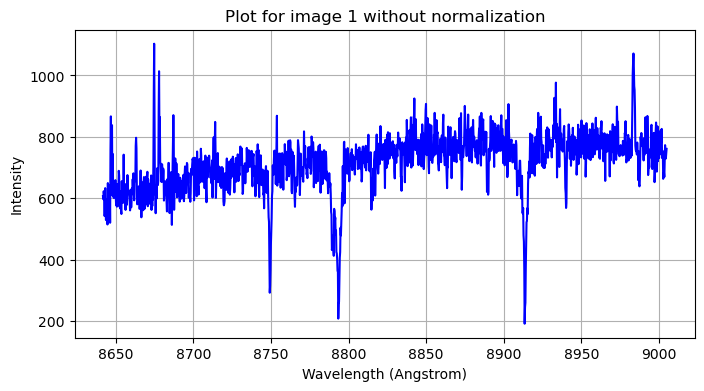

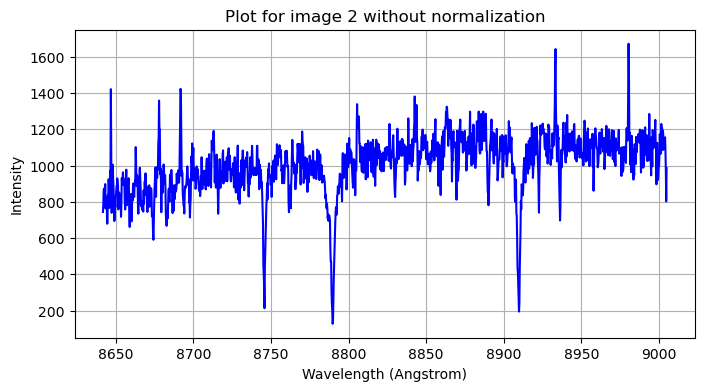

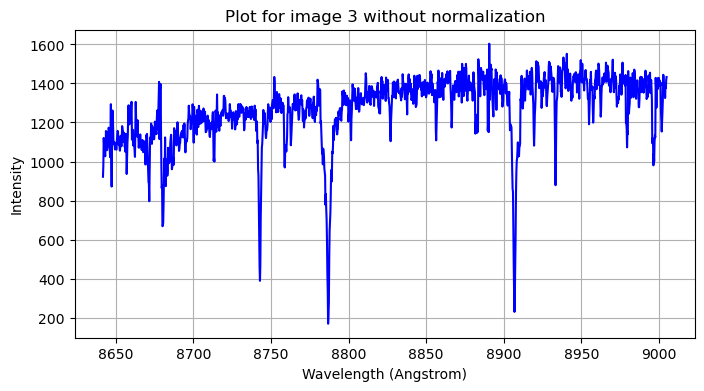

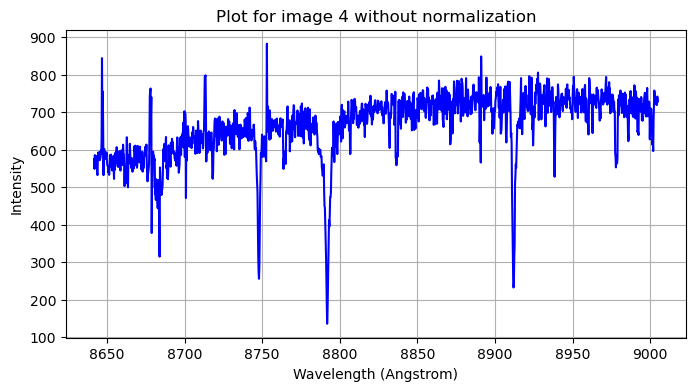

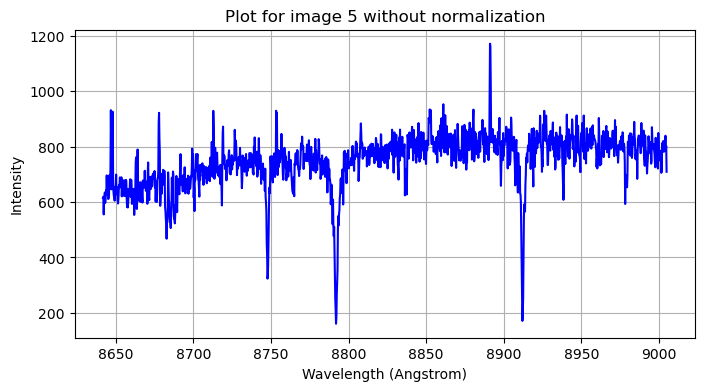

In [4]:
for i, array in enumerate(spectraData):
    plt.figure(figsize = (8,4))
    plt.plot(wlRanges[i], array[:len(wlRanges[i])], color = 'b')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.title(f'Plot for image {i+1} without normalization')
    plt.grid(True)
    
plt.show()

# Finding the Max Value Normalization

In [62]:
normalizedValues = []
for spectrum in spectraData:
    maxValue = spectrum.max(axis = 0)
    normalizedValue = spectrum/maxValue
    normalizedValues.append(normalizedValue)

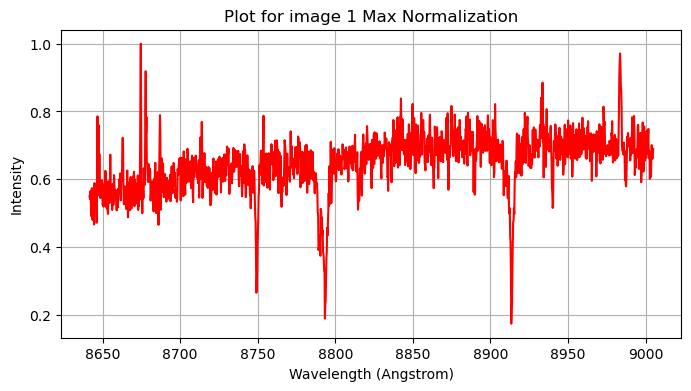

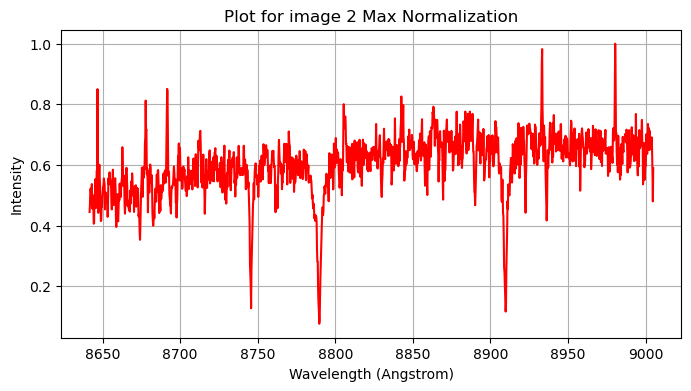

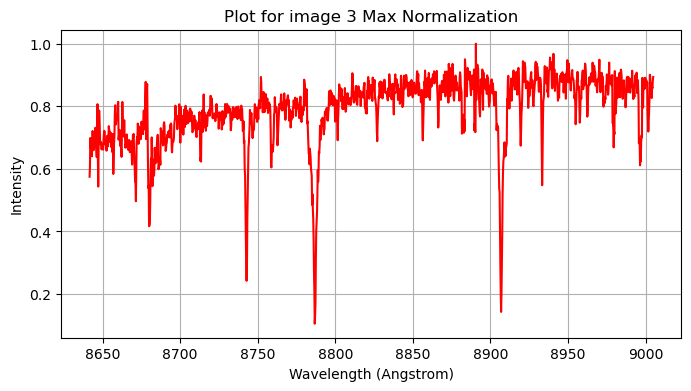

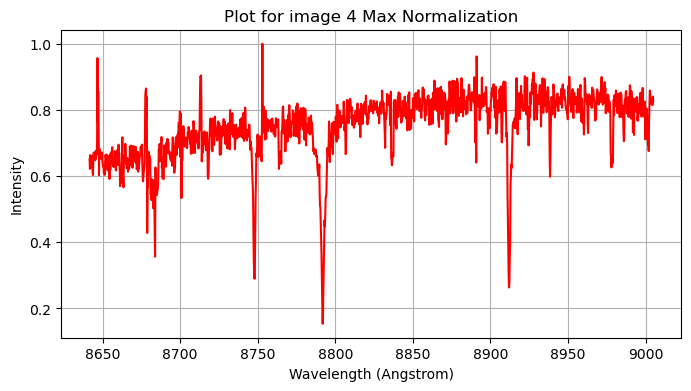

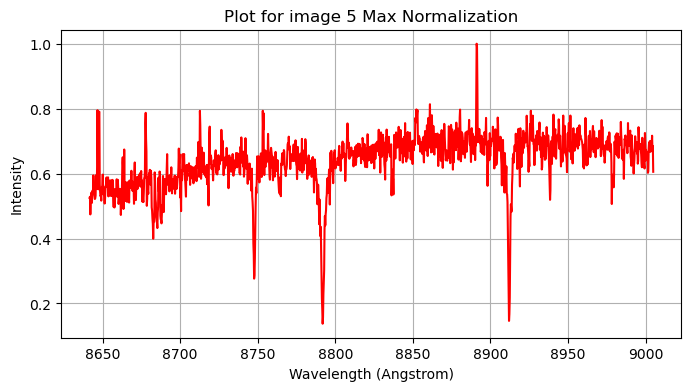

In [63]:
for i, array in enumerate(normalizedValues):
    plt.figure(figsize = (8,4))
    plt.plot(wlRanges[i], array[:len(wlRanges[i])], color = 'r')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.title(f'Plot for image {i+1} Max Normalization')
    plt.grid(True)
    
plt.show()

# Finding the Total Flux Normalization

In [64]:
normalizedValues = []
for spectrum in spectraData:
    totalFlux = spectrum.sum(axis = 0)
    normalizedValue = spectrum/totalFlux
    normalizedValues.append(normalizedValue)

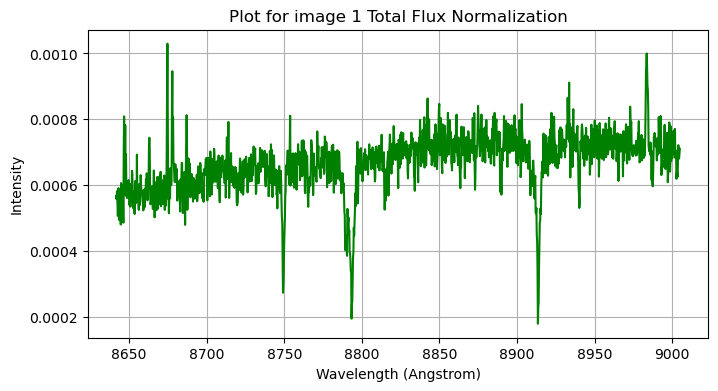

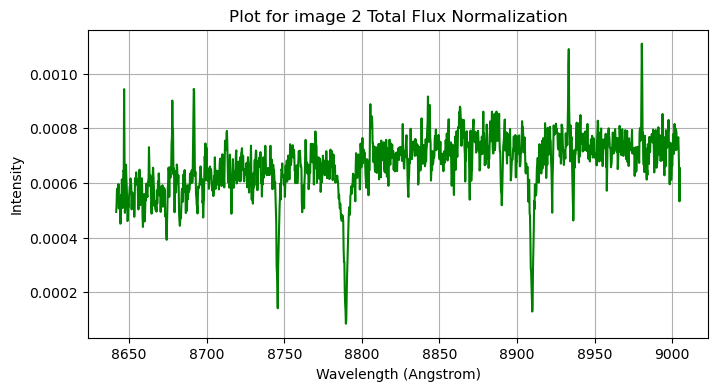

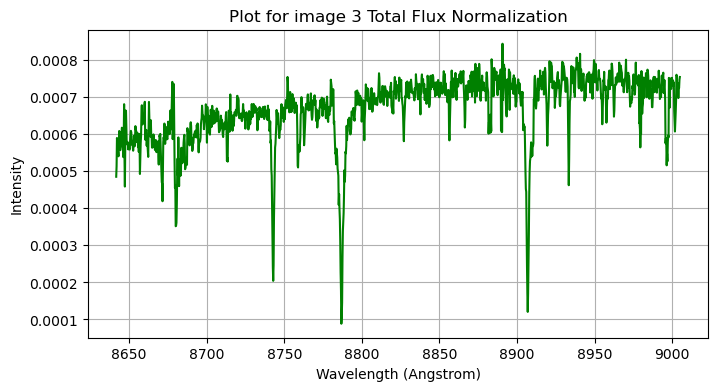

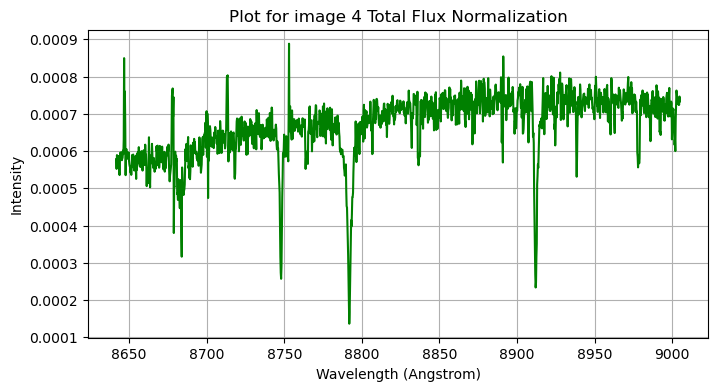

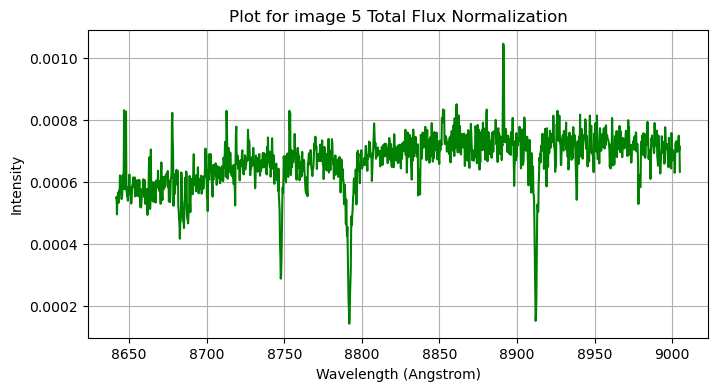

In [65]:
for i, array in enumerate(normalizedValues):
    plt.figure(figsize = (8,4))
    plt.plot(wlRanges[i], array[:len(wlRanges[i])], color = 'g')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.title(f'Plot for image {i+1} Total Flux Normalization')
    plt.grid(True)
    
plt.show();

# Finding the Median Value Flux Normalization

In [5]:
normalizedValues = []
for spectrum in spectraData:
    medianValue = np.median(spectrum, axis = 0)
    normalizedValue = spectrum/medianValue
    normalizedValues.append(normalizedValue)

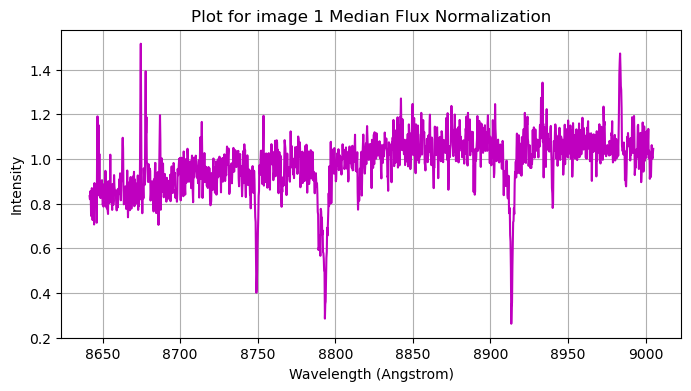

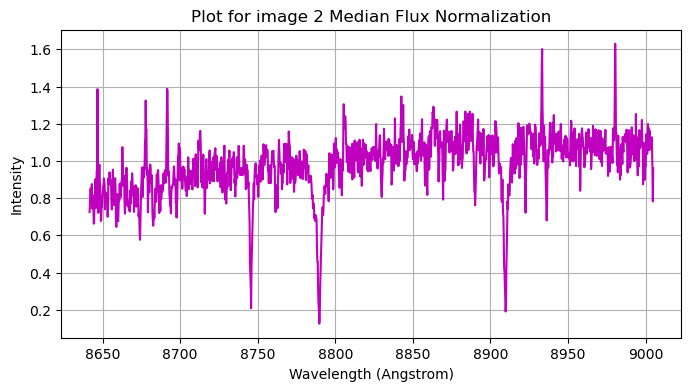

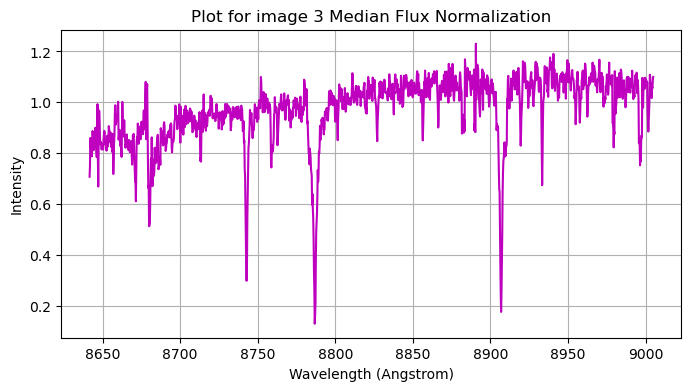

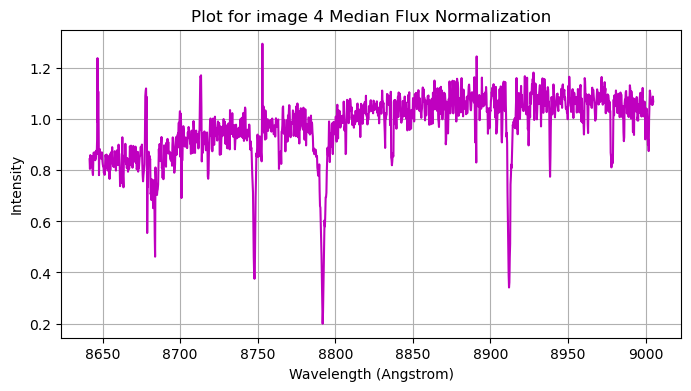

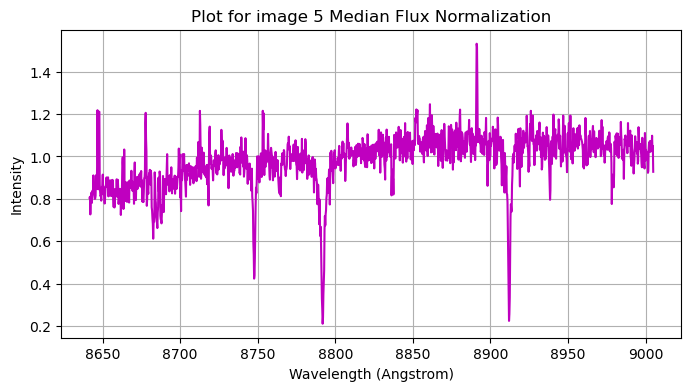

In [7]:
for i, array in enumerate(normalizedValues):
    plt.figure(figsize = (8,4))
    plt.plot(wlRanges[i], array[:len(wlRanges[i])], color = 'm')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.title(f'Plot for image {i+1} Median Flux Normalization')
    plt.grid(True)
    
plt.show();

# Continuum Fitting

In [5]:
normalizedValues = []
for spectrum in spectraData:
    medianValue = np.median(spectrum, axis = 0)
    normalizedValue = spectrum/medianValue
    normalizedValues.append(normalizedValue)

In [6]:
polyFits = []
normedSpectraY =[]

for i in range(len(normalizedValues)):
    smoothIntensity = np.convolve(normalizedValues[i], np.ones(10)/10, mode = 'same')
    data = smoothIntensity * u.Jy
    x = wlRanges[i] * u.angstrom
    spectrum = Spectrum1D(flux = data, spectral_axis = x)
    
    g1Fit = fit_generic_continuum(spectrum, median_window = 3, model = models.Polynomial1D(5),
                              fitter = LevMarLSQFitter(),
                              exclude_regions = [SpectralRegion(8725 * u.angstrom, 8750 * u.angstrom), SpectralRegion(8775 * u.angstrom, 8800 * u.angstrom),
                                                 SpectralRegion(8900 * u.angstrom, 8925 * u.angstrom), SpectralRegion(8995 * u.angstrom, 9000 * u.angstrom),
                                                 SpectralRegion(8650 * u.angstrom, 8656 * u.angstrom)])
    y = g1Fit(x)
    yNorm = data / y
    
    polyFits.append(y)
    normedSpectraY.append(yNorm)


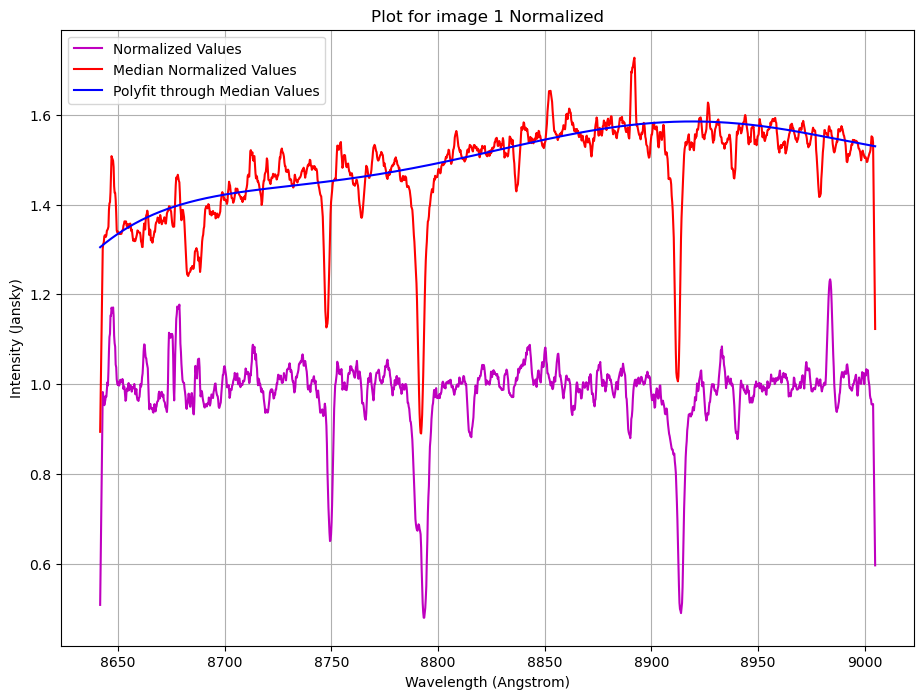

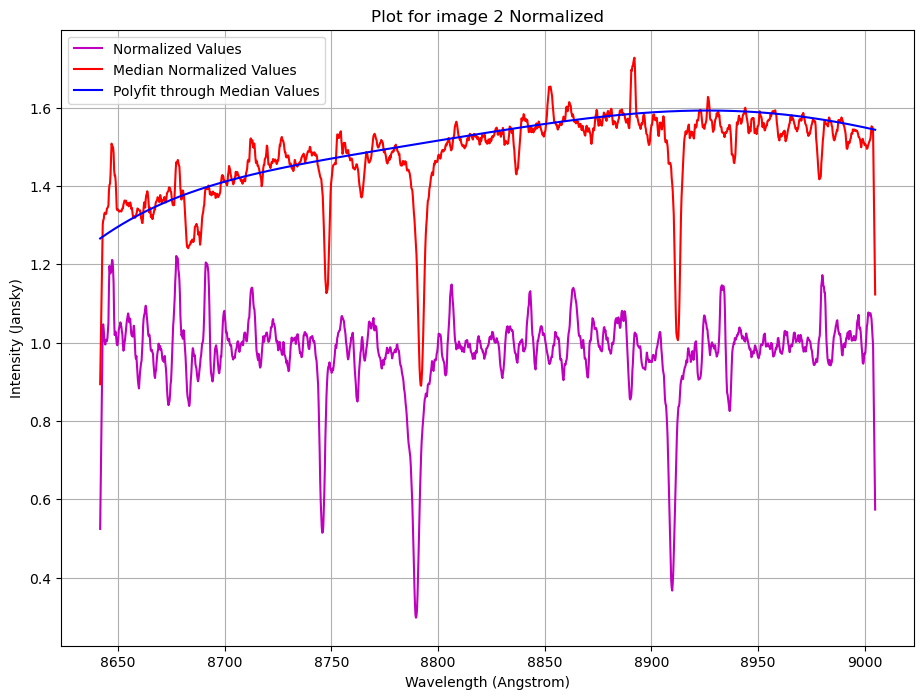

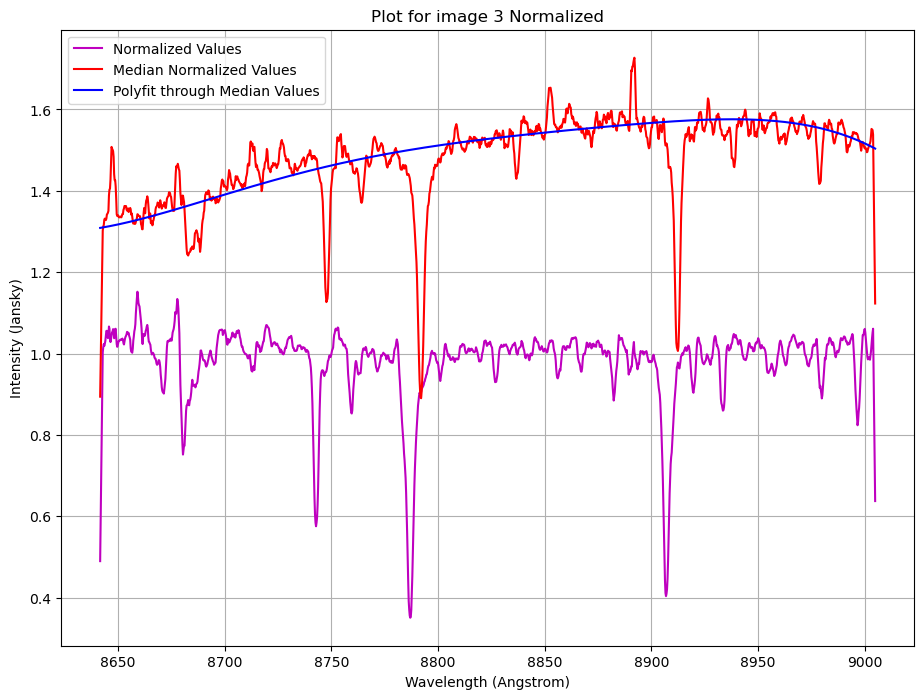

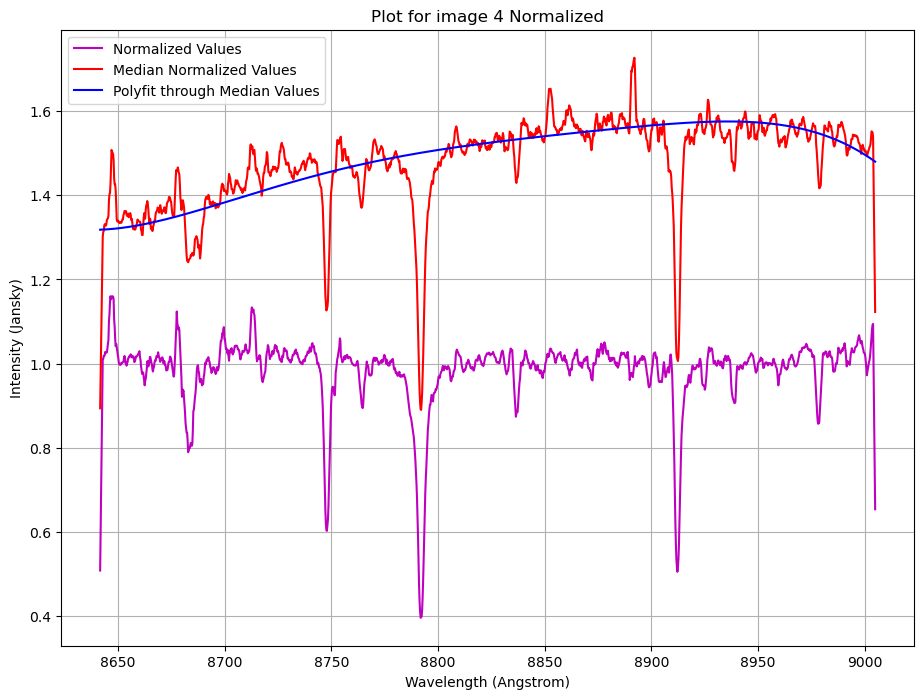

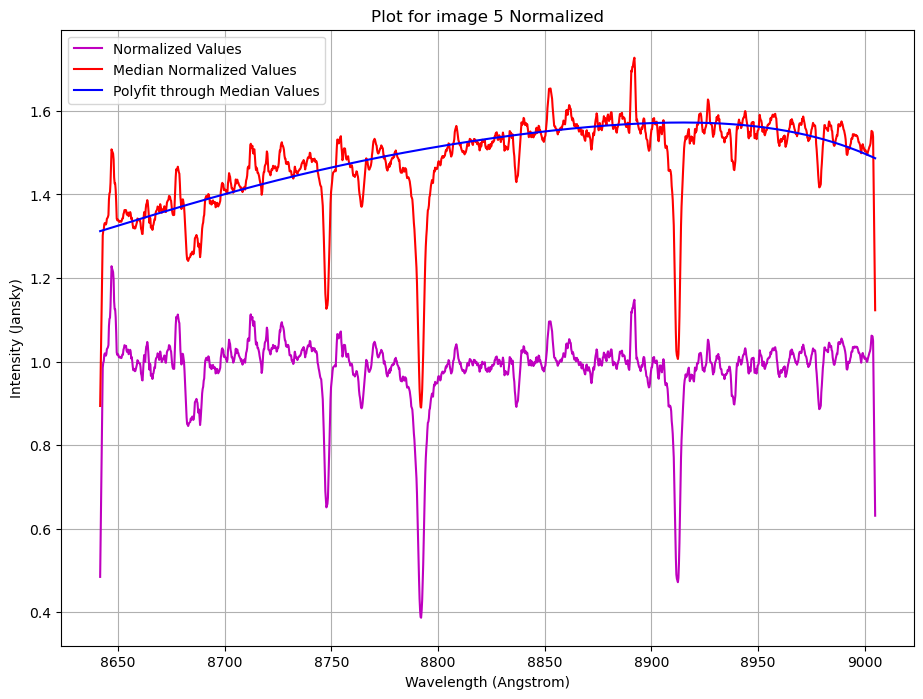

In [7]:
for i, array in enumerate(normedSpectraY):
    
    plt.figure(figsize = (11,8))
    plt.plot(wlRanges[i], array[:len(wlRanges[i])], color = 'm', label = 'Normalized Values')
    plt.plot(wlRanges[i], smoothIntensity+0.5, color = 'r', label = 'Median Normalized Values')
    plt.plot(wlRanges[i], (polyFits[i]/u.Jy)+0.5, color = 'b', label = 'Polyfit through Median Values')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity (Jansky)')
    plt.title(f'Plot for image {i+1} Normalized')
    plt.legend(loc = 'best')
    plt.grid(True)
    
plt.show()

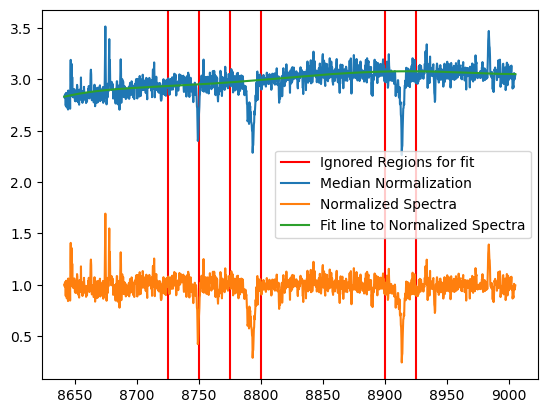

In [23]:
x = wlRanges[0] * u.angstrom

plt.axvline(x=8725, color = 'r', label='Ignored Regions for fit')
plt.axvline(x=8750, color = 'r')
plt.axvline(x=8775, color = 'r')
plt.axvline(x=8800, color = 'r')
plt.axvline(x=8900, color = 'r')
plt.axvline(x=8925, color = 'r')
plt.plot(x, normalizedValues[0]+2, label='Median Normalization')
plt.plot(x, normedSpectraY[0], label = 'Normalized Spectra')
plt.plot(x, (polyFits[0]/u.Jy)+2, label = 'Fit line to Normalized Spectra')
plt.legend(loc = 'best');

In [8]:
spectrumData = spectraData[0] * u.Jy
x = wlRanges[0] * u.angstrom
spectrum = Spectrum1D(flux = spectrumData, spectral_axis = x)

g1Fit = fit_generic_continuum(spectrum, median_window = 3, model = models.Polynomial1D(7),
                              fitter = LevMarLSQFitter(),
                              exclude_regions = [SpectralRegion(8725 * u.angstrom, 8750 * u.angstrom), SpectralRegion(8775 * u.angstrom, 8800 * u.angstrom),
                                                 SpectralRegion(8900 * u.angstrom, 8925 * u.angstrom), SpectralRegion(8995 * u.angstrom, 9000 * u.angstrom),
                                                 SpectralRegion(8650 * u.angstrom, 8656 * u.angstrom)])

In [9]:
y = g1Fit(x)

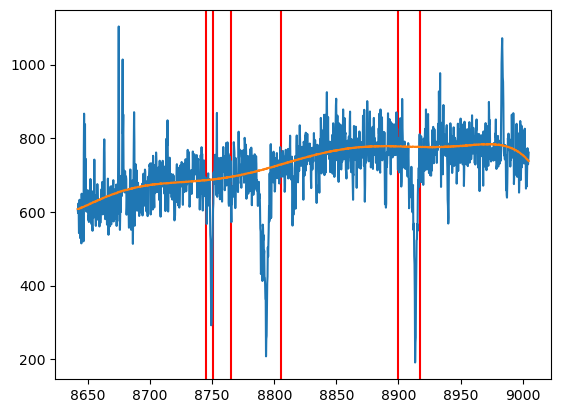

In [10]:
plt.axvline(x=8745, color = 'r')
plt.axvline(x=8751, color = 'r')
plt.axvline(x=8765, color = 'r')
plt.axvline(x=8805, color = 'r')
plt.axvline(x=8900, color = 'r')
plt.axvline(x=8917, color = 'r')
plt.plot(x, spectrumData)
plt.plot(x, y);

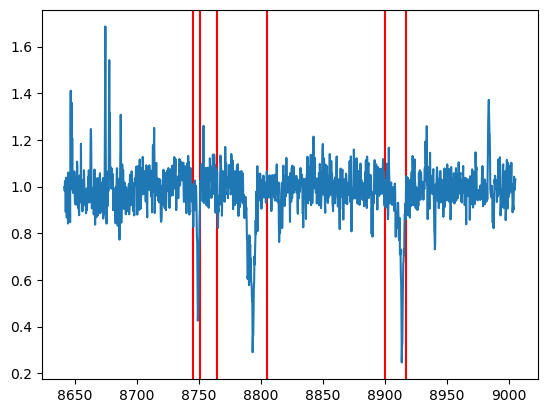

In [58]:
normalize = spectrumData / y
plt.axvline(x=8745, color = 'r')
plt.axvline(x=8751, color = 'r')
plt.axvline(x=8765, color = 'r')
plt.axvline(x=8805, color = 'r')
plt.axvline(x=8900, color = 'r')
plt.axvline(x=8917, color = 'r')
plt.plot(x, normalize)